<a href="https://colab.research.google.com/github/GhTara/Mnist_HMM/blob/main/hmm_and_hybrid_hmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist  
import cv2


In [ ]:
!pip install hmmlearn
from hmmlearn import hmm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/package/

In [ ]:
# !tar -xvf /content/drive/MyDrive/package/sequentia-0.12.0.tar.gz

In [ ]:
%cd /content/drive/MyDrive/package/sequentia-0.12.0

In [ ]:
!pip install dtaidistance
!pip install torchfsdd

In [ ]:
pip install requirements-parser

In [ ]:
! pip install gevent --pre
! pip install auto-py-to-exe

In [ ]:
!pip install .

#DCT

In [ ]:
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc 
import matplotlib.pylab as pylab

%matplotlib inline

In [ ]:
!pip install Pillow

In [ ]:
from scipy import fftpack
def dct2(a):
    return fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

In [ ]:
! pip install scipy

#Load Dataset

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


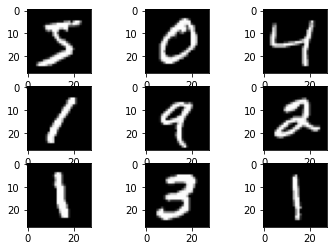

In [ ]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [ ]:
# convert from integers to floats
trainX_norm = trainX.astype('float32')
testX_norm = testX.astype('float32')
# normalize to range 0-1
trainX = trainX_norm / 255.0
testX = testX_norm / 255.0

#Define Functions

##to get top left corner

In [ ]:
def extract_lowfreq(img, th):
  clip_off = int(np.sqrt(th*2))
  img = img[:clip_off,:clip_off]
  s = clip_off*(clip_off+1)/2
  img_filp = cv2.flip(img, 0) #flip over x axis
  anti_orth = np.tril(img_filp, 0)
  # print(anti_orth)
  feature_vec = anti_orth.flatten('F')
  feature_vec = [ele for ele in list(feature_vec) if ele!=0]
  while len(feature_vec) < s:
    feature_vec.append(0)
  # print(len(feature_vec))
  return feature_vec
  

In [ ]:
trainX_norm[0].shape

(28, 28)

In [ ]:
x = extract_lowfreq(dct2(trainX_norm[0]),45)
np.array(x).shape

(45,)

In [ ]:
def extract_featue(x, th):
  feature_vector = []
  x_end = 10
  while 1:
    if x_end <= 28:
      feature = extract_lowfreq(dct2(x[:,:x_end]),th)
    else:
      break
    x_end += 1
    feature_vector.append(feature)


  x_start = 1
  while 1:
    if 28 - x_start >= 10:
      feature = extract_lowfreq(dct2(x[:,x_start:]),th)
    else:
      break
    x_start += 1
    feature_vector.append(feature)
  return feature_vector


In [ ]:
np.array(extract_featue(trainX_norm[1], 45)).shape

(37, 45)

In [ ]:
def prepare_data_dct_horiz(x,y):
  ds={}
  for i in list(set(y)):
    ds[i]=[]
  for i in range(len(x)):
    # print(i)
    feature_vec = extract_featue(x[i], 45)
    if len(ds[y[i]]):
      # print(str(j) +': {}, {}'.format(np.array(feature_vec).shape, np.array(ds[y[j]]).shape))
      ds[y[i]] = np.concatenate([ds[y[i]],feature_vec])
    else:
      ds[y[i]] = feature_vec
    
  return ds

In [ ]:
trainds = prepare_data_dct_horiz(trainX[:20], trainy[:20])

In [ ]:
trainX[:20].shape

(20, 28, 28)

In [ ]:
np.array(trainds[0]).reshape(len(trainds[0])//37, 37, 45).shape

(1, 37, 45)

In [ ]:
extract_lowfreq(cv2.dct(trainX_norm[0]), 27, 27)

##get salient feature

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
def sift_descriptor(x):
    """
    Create the SIFT descriptor of an image.
    """
    # image = cv2.imread(data)
    grey_img = x
    # grey_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(grey_img, None)
    return des

(11, 128)

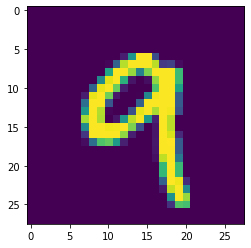

In [ ]:
plt.imshow(trainX[110])
np.array(sift_descriptor(trainX[110])).shape


In [ ]:
def prep_data_sift(x,y):
  length = {}
  ds={}
  for i in list(set(y)):
    ds[i]=[]
  for i in range(len(x)):
    feature = sift_descriptor(x[i])
    if len(ds[y[i]]):
      if feature is None:
        # print(y[i])
        continue
      else:
        length[y[i]].append(feature.shape[0])
        # for hmmlearn package
        # ds[y[i]] = np.concatenate([ds[y[i]],feature]) 
        # for sequentia
        ds[y[i]].append(feature)
    else:
      # for hmmlearn
      # ds[y[i]] = feature
      # for sequentia
      ds[y[i]] = [feature]
      length[y[i]] = [feature.shape[0]]
  return length, ds

In [ ]:
length_train, training_set = prep_data_sift(trainX, trainy)
length_test, test_set = prep_data_sift(testX, testy)

In [ ]:
np.array(training_set[7][1]).shape

(3, 128)

##extract feature as row bsed

In [ ]:
# x = X_train[0]
# for i in range(1,6):
#   x = np.concatenate([x,X_train[i]])

def prep_data_row(x, y):
  ds={}
  for i in list(set(y)):
    ds[i]=[]
  for i in range(len(x)):
    if len(ds[y[i]]):
      ds[y[i]] = np.concatenate([ds[y[i]],x[i]])
    else:
      ds[y[i]] = x[i]

  return ds

In [ ]:
training_set=prep_data_row(trainX_norm,trainy)
test_set=prep_data_row(testX_norm,testy)

In [ ]:

np.array(training_set[0]).shape

(52895, 128)

In [ ]:
# X1 = np.random.random((10, 2))  # 2-D
# X2 = np.random.random((5, 2))   # must have the same ndim as X1.
# X = np.concatenate([X1, X2])
# print(X.shape)
# lengths = np.array([len(X1), len(X2)])
# hmm.GaussianHMM(n_components=2).fit(X, lengths)
# # GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
# #       covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
# #       min_covar=0.001, n_components=2, n_iter=10, params='stmc',
# #       random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
# #       verbose=False)


(15, 2)


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

##v3

In [ ]:
np.array(trainds[0]).shape

(37, 45)

In [ ]:
# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [ ]:
from tqdm.auto import tqdm
from sequentia.classifiers import GMMHMM, HMMClassifier

In [ ]:
from sklearn.model_selection import KFold
# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(5, True, 42)

In [ ]:
# Merge inputs and targets
images = np.concatenate((trainX[:], testX[:]), axis=0)
labels = np.concatenate((trainy[:], testy[:]), axis=0)

fold_no = 1
epochs = 150
acc_f = []
cm_f = []
loss_per_fold = []
rec_per_fold = []
dist = len(images)//5
for i in range(5):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  test_x = list(images)[i*dist:i*dist+dist]
  test_y = list(labels)[i*dist:i*dist+dist]

  if i != 4:
    train_x = list(images)[:i*dist] + list(images)[i*dist+dist:] 
    train_y = list(labels)[:i*dist] + list(labels)[i*dist+dist:] 
  else:
    train_x = list(images)[:i*dist]
    train_y = list(labels)[:i*dist]

  train_x = np.array(train_x)
  train_y = np.array(train_y)
  test_x = np.array(test_x)
  test_y = np.array(test_y)


  trainData = prepare_data_dct_horiz(train_x, train_y)
  print(trainData[digit].shape)
  print(np.array(trainData[digit]).reshape(len(trainData[digit])//37, 37, 45).shape)
  hmms = []

  for digit in tqdm(list(set(testy)), desc='Training HMMs'):
      print(digit)
      # Create a linear HMM with 5 states and 10 components in the GMM emission state distributions
      hmm = GMMHMM(label=digit, n_states=10, random_state=rng, covariance_type='diag')
      # Set random initial state distributions and transition matrix according to the linear topology
      hmm.freeze('c')
      hmm.set_random_initial()
      hmm.set_random_transitions()
      # Fit each HMM only on the observation sequences which had that label
      # trainData = np.array(trainData[digit])
      hmm.fit(list(np.array(trainData[digit]).reshape(len(trainData[digit])//37, 37, 45)))
      hmms.append(hmm)
      
  clf = HMMClassifier()
  clf.fit(hmms)

  test = []
  label_t = []
  testyy = test_y
  testxx = test_x
  for i in range(len(testyy)):
    test.append(np.array(extract_featue(testxx[i], 45)))
    label_t.append(testyy[i])
  
  acc, cm = clf.evaluate(test, label_t, n_jobs=1)
  acc_f.append(acc)
  cm_f.append(cm)

  fold_no += 1




------------------------------------------------------------------------
Training for fold 1 ...
(205757, 45)
(5561, 37, 45)


0
1
2
3
4
5
6
7
8
9




------------------------------------------------------------------------
Training for fold 2 ...
(205720, 45)
(5560, 37, 45)


0
1
2
3
4
5
6
7
8
9




------------------------------------------------------------------------
Training for fold 3 ...
(205091, 45)
(5543, 37, 45)


0
1
2
3
4
5
6
7
8
9




------------------------------------------------------------------------
Training for fold 4 ...
(207533, 45)
(5609, 37, 45)


0
1
2
3
4
5
6
7
8
9




------------------------------------------------------------------------
Training for fold 5 ...
(205683, 45)
(5559, 37, 45)


0
1
2
3
4
5
6
7
8
9



In [ ]:
trainData.shape

In [ ]:
labels[train]

**for 200 data**

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_f)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Accuracy: {acc_f[i]}% ')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_f)} (+- {np.std(acc_f)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 0.6% 
------------------------------------------------------------------------
> Fold 2 - Accuracy: 0.525% 
------------------------------------------------------------------------
> Fold 3 - Accuracy: 0.65% 
------------------------------------------------------------------------
> Fold 4 - Accuracy: 0.55% 
------------------------------------------------------------------------
> Fold 5 - Accuracy: 0.525% 
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.5700000000000001 (+- 0.04847679857416329)
------------------------------------------------------------------------


**for 2000 data**

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_f)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Accuracy: {acc_f[i]}% ')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_f)} (+- {np.std(acc_f)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 0.56% 
------------------------------------------------------------------------
> Fold 2 - Accuracy: 0.47% 
------------------------------------------------------------------------
> Fold 3 - Accuracy: 0.5425% 
------------------------------------------------------------------------
> Fold 4 - Accuracy: 0.4975% 
------------------------------------------------------------------------
> Fold 5 - Accuracy: 0.6125% 
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.5365 (+- 0.04961350622562371)
------------------------------------------------------------------------


**all data**

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_f)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Accuracy: {acc_f[i]}% ')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_f)} (+- {np.std(acc_f)})')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 0.5623571428571429% 
------------------------------------------------------------------------
> Fold 2 - Accuracy: 0.5499285714285714% 
------------------------------------------------------------------------
> Fold 3 - Accuracy: 0.5448571428571428% 
------------------------------------------------------------------------
> Fold 4 - Accuracy: 0.5693571428571429% 
------------------------------------------------------------------------
> Fold 5 - Accuracy: 0.635% 
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.5722999999999999 (+- 0.03253429587624828)
------------------------------------------------------------------------


In [ ]:
hmms[0].n_components

2

In [ ]:
test = []
label_t = []
testyy = testy[:2000]
testxx = testX[:2000]
for i in range(len(testyy)):
  test.append(np.array(extract_featue(testxx[i], 45)))
  label_t.append(testyy[i])
  


## Hybrid model

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
from tensorflow.keras import metrics
model = keras.Sequential([keras.layers.Flatten(input_shape=(1,10)),
                # keras.layers.Dense(10,activation = tf.nn.sigmoid),                          
                keras.layers.Dense(10,activation = tf.nn.softmax)])
model.compile(optimizer = 'adam',loss='categorical_crossentropy',metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [ ]:
test = []
label_t = []
yy = labels
xx = images
for i in range(len(yy)):
  test.append(np.array(extract_featue(xx[i], 45)))
  label_t.append(yy[i])

In [ ]:
predictions = clf.predict(test)

In [ ]:
predictions = predictions.reshape(len(predictions),1,10)

In [ ]:
from tensorflow.keras.utils import to_categorical

predictions = to_categorical(predictions)
label = to_categorical(label_t)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
 history = model.fit(predictions, label,epochs = 150, validation_split=0.1, callbacks=[early_stop], verbose=1)

Epoch 1/150
1969/1969 [==============================] - 3s 2ms/step - loss: 1.3304 - accuracy: 0.6160 - precision_1: 0.6782 - recall_1: 0.4063 - val_loss: 1.1741 - val_accuracy: 0.6491 - val_precision_1: 0.6908 - val_recall_1: 0.5299
Epoch 2/150
1969/1969 [==============================] - 9s 5ms/step - loss: 1.2124 - accuracy: 0.6233 - precision_1: 0.6531 - recall_1: 0.5566 - val_loss: 1.1290 - val_accuracy: 0.6491 - val_precision_1: 0.6682 - val_recall_1: 0.6111
Epoch 3/150
1969/1969 [==============================] - 3s 2ms/step - loss: 1.1913 - accuracy: 0.6233 - precision_1: 0.6509 - recall_1: 0.5701 - val_loss: 1.1174 - val_accuracy: 0.6491 - val_precision_1: 0.6720 - val_recall_1: 0.5910
Epoch 4/150
1969/1969 [==============================] - 3s 1ms/step - loss: 1.1852 - accuracy: 0.6233 - precision_1: 0.6528 - recall_1: 0.5649 - val_loss: 1.1129 - val_accuracy: 0.6491 - val_precision_1: 0.6720 - val_recall_1: 0.5910
Epoch 5/150
1969/1969 [==============================] - 3s 